In [46]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image
import seaborn as sns

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer
model.eval()

# Optionally, move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the transformation pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract frames from a video file
def extract_frames(video_path, num_frames=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    # read only 30 frames
    count = 0
    while cap.isOpened() :
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(Image.fromarray(frame))
        count += 1

    cap.release()
    return frames

# Function to extract features from a video (assuming video is a list of frames)
# Function to extract features from a video (assuming video is a list of frames)
def extract_features(video_frames):
    features_list = []
    for frame in video_frames:
        input_tensor = preprocess(frame).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model(input_tensor)
        features = features.view(features.size(0), -1)  # Flatten to (batch_size, 2048)

        features_list.append(features.cpu().numpy())
    
    return features_list

# Visualize features using PCA or t-SNE
def visualize_features(features, method='pca'):
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        reduced_features = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=range(len(reduced_features)), cmap='viridis')
    plt.colorbar()
    plt.title(f'Feature Visualization ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Visualize features as a heatmap
def visualize_heatmap(features, method='sum'):
    if method == 'sum':
        heatmap = np.sum(features, axis=0)  # Sum over all frames
    elif method == 'mean':
        heatmap = np.mean(features, axis=0)  # Average over all frames
    
    heatmap = heatmap.squeeze()  # Remove unnecessary dimensions
    
    # Normalize the heatmap for better visualization
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()

    plt.figure(figsize=(10, 7))
    sns.heatmap(heatmap, cmap='viridis')
    plt.title(f'Feature Heatmap ({method.upper()})')
    plt.show()

# Main function to process the video and visualize features
def process_video(video_path):
    video_frames = extract_frames(video_path)
    features = extract_features(video_frames)  # List of (1, 2048) feature vectors
    features_np = np.concatenate(features, axis=0)  # Shape: (num_frames, 2048)
    return features_np



/home/cjh9fw/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cjh9fw/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
# Example usage
video_path = '/standard/storage/CognitiveEMS_Datasets/North_Garden/May_2024/DO_NOT_DELETE/ego_camera/ng1/0/GX010305_clipped.mp4'  # Replace with your video file path
features = process_video(video_path)
print(features.shape)  # (num_frames, 2048)


(4632, 2048)


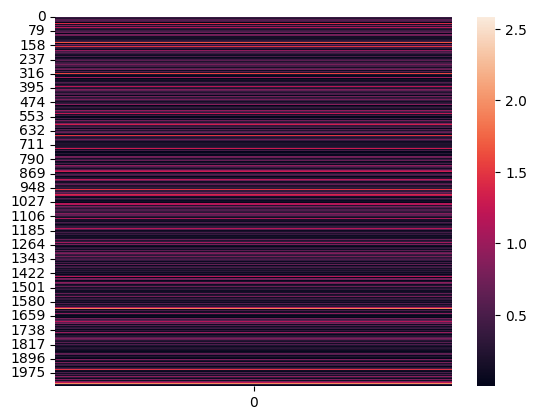

In [53]:

# flip axis
features = np.transpose(features)
ax = sns.heatmap(features[:,0:1])


In [28]:
# Visualize features using PCA
# visualize_features(features, method='pca')

# Visualize features using t-SNE (optional)
visualize_heatmap(features, method='sum')

IndexError: Inconsistent shape between the condition and the input (got (2048, 1) and (2048,))

<Figure size 1000x700 with 0 Axes>